In [ ]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/MyDrive/PDS/PDS_PROJECT_DATA/speech-emotion-recognition-ravdess-data"

In [ ]:
import os
import librosa
import pandas as pd
from tqdm import tqdm

def verify_wav_files_in_nested_folders(root_folder):

    # Collect all WAV files recursively
    wav_files = []
    for root, _, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith('.wav'):
                wav_files.append(os.path.join(root, file))

    if not wav_files:
        print(f"No WAV files found in {root_folder} or its subfolders")
        return None

    print(f"Found {len(wav_files)} WAV files to verify")

    results = []

    for file_path in tqdm(wav_files, desc="Verifying WAV files"):
        rel_path = os.path.relpath(file_path, start=root_folder)
        file_info = {
            'filename': os.path.basename(file_path),
            'relative_path': rel_path,
            'file_path': file_path,
            'valid': False,
            'duration': None,
            'sample_rate': None,
            'channels': None,
            'error': None
        }

        try:
            # Try loading the file with librosa
            y, sr = librosa.load(file_path, sr=None, mono=False)

            # Get duration
            duration = librosa.get_duration(y=y, sr=sr)

            # Determine channels (mono returns 1D array, stereo 2D)
            channels = 1 if len(y.shape) == 1 else y.shape[0]

            # Update file info
            file_info.update({
                'valid': True,
                'duration': duration,
                'sample_rate': sr,
                'channels': channels
            })

        except Exception as e:
            file_info['error'] = str(e)

        results.append(file_info)

    # Convert to DataFrame
    df_results = pd.DataFrame(results)

    # Calculate verification stats
    valid_count = df_results['valid'].sum()
    invalid_count = len(df_results) - valid_count
    print(f"\nVerification complete: {valid_count} valid, {invalid_count} invalid")

    if invalid_count > 0:
        print("\nInvalid files:")
        print(df_results[df_results['valid'] == False][['relative_path', 'error']])

    return df_results



In [ ]:
verify_wav_files_in_nested_folders(dataset_path)

Found 1440 WAV files to verify


Verifying WAV files: 100%|██████████| 1440/1440 [20:05<00:00,  1.19it/s]


Verification complete: 1440 valid, 0 invalid


filename                      relative_path  \
0     03-01-03-01-01-01-02.wav  Actor_02/03-01-03-01-01-01-02.wav   
1     03-01-02-02-01-01-02.wav  Actor_02/03-01-02-02-01-01-02.wav   
2     03-01-03-02-02-01-02.wav  Actor_02/03-01-03-02-02-01-02.wav   
3     03-01-01-01-01-02-02.wav  Actor_02/03-01-01-01-01-02-02.wav   
4     03-01-02-02-02-02-02.wav  Actor_02/03-01-02-02-02-02-02.wav   
...                        ...                                ...   
1435  03-01-08-01-01-02-24.wav  Actor_24/03-01-08-01-01-02-24.wav   
1436  03-01-07-02-01-02-24.wav  Actor_24/03-01-07-02-01-02-24.wav   
1437  03-01-08-01-02-02-24.wav  Actor_24/03-01-08-01-02-02-24.wav   
1438  03-01-08-02-01-01-24.wav  Actor_24/03-01-08-02-01-01-24.wav   
1439  03-01-08-02-02-02-24.wav  Actor_24/03-01-08-02-02-02-24.wav   

                                              file_path  valid  duration  \
0     /content/drive/MyDrive/PDS/PDS_PROJECT_DATA/sp...   True  3.603625   
1     /content/drive/MyDrive/PDS/PDS_PROJECT_DATA/sp...   True  4.137500   
2     /content/drive/MyDrive/PDS/PDS_PROJECT_DATA/sp...   True  3.703688   
3     /content/drive/MyDrive/PDS/PDS_PROJECT_DATA/sp...   True  3.603625   
4     /content/drive/MyDrive/PDS/PDS_PROJECT_DATA/sp...   True  4.104125   
...                                                 ...    ...       ...   
1435  /content/drive/MyDrive/PDS/PDS_PROJECT_DATA/sp...   True  3.470125   
1436  /content/drive/MyDrive/PDS/PDS_PROJECT_DATA/sp...   True  4.637937   
1437  /content/drive/MyDrive/PDS/PDS_PROJECT_DATA/sp...   True  3.403375   
1438  /content/drive/MyDrive/PDS/PDS_PROJECT_DATA/sp...   True  3.937250   
1439  /content/drive/MyDrive/PDS/PDS_PROJECT_DATA/sp...   True  3.636938   

      sample_rate  channels error  
0           16000         1  None  
1           16000         1  None  
2           16000         1  None  
3           16000         1  None  
4           16000         1  None  
...           ...       ...   ...  
1435        16000         1  None  
1436        16000         1  None  
1437        16000         1  None  
1438        16000         1  None  
1439        16000         1  None  

[1440 rows x 8 columns]

In [ ]:
import os
import pandas as pd
from collections import defaultdict
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Define LABELS globally
LABELS = {
    'modality': {
        '01': 'full-AV', '02': 'video-only', '03': 'audio-only'
    },
    'vocal_channel': {
        '01': 'speech', '02': 'song'
    },
    'emotion': {
        '01': 'neutral', '02': 'calm', '03': 'happy',
        '04': 'sad', '05': 'angry', '06': 'fearful',
        '07': 'disgust', '08': 'surprised'
    },
    'intensity': {
        '01': 'normal', '02': 'strong'
    },
    'statement': {
        '01': 'Kids talking', '02': 'Dogs sitting'
    },
    'repetition': {
        '01': '1st', '02': '2nd'
    }
}

def analyze_and_report_wav_files(root_folder):


    # Initialize data structures
    counts = {category: defaultdict(int) for category in LABELS}
    counts.update({'actor': defaultdict(int), 'gender': defaultdict(int)})
    file_data = []

    # Process files
    for root, _, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith('.wav'):
                parts = file.split('.')[0].split('-')
                if len(parts) == 7:
                    modality, vocal, emotion, intensity, statement, repetition, actor = parts
                    gender = 'female' if int(actor) % 2 == 0 else 'male'

                    # Update counts
                    counts['modality'][modality] += 1
                    counts['vocal_channel'][vocal] += 1
                    counts['emotion'][emotion] += 1
                    counts['intensity'][intensity] += 1
                    counts['statement'][statement] += 1
                    counts['repetition'][repetition] += 1
                    counts['actor'][actor] += 1
                    counts['gender'][gender] += 1

                    file_data.append({
                        'filename': file,
                        **{k: v for k, v in zip(LABELS.keys(), parts)},
                        'actor': actor,
                        'gender': gender
                    })

    # Convert to human-readable format
    readable_counts = {}
    for category in counts:
        if category in LABELS:
            readable_counts[category] = {
                LABELS[category].get(k, k): v
                for k, v in counts[category].items()
            }
        else:
            readable_counts[category] = dict(counts[category])

    # Generate and display reports
    display(HTML(generate_text_report(readable_counts)))
    generate_visual_report(readable_counts)  # Display chart directly
    # save_detailed_data(file_data, output_dir)  # Removed saving to file

    print(f"\nReports displayed in the console.")

def generate_text_report(counts):
    """Generate formatted text report as HTML"""
    report_lines = ["<h3>=== WAV FILE ANALYSIS REPORT ===</h3>",
                   f"<p>Total files analyzed: {sum(counts['modality'].values())}</p>"]

    # Create tables for each category
    for category, items in counts.items():
        if category == 'actor':  # Handle actors separately
            continue

        table = []
        for item, count in items.items():
            table.append([item, count, f"{count/sum(items.values()):.1%}"])

        report_lines.append(f"<h4>{category.upper().replace('_', ' ')}</h4>")
        report_lines.append(tabulate(table, headers=['Item', 'Count', 'Percentage'], tablefmt='html'))

    # Actor table
    actors = sorted(counts['actor'].items(), key=lambda x: int(x[0]))
    actor_table = [[f"Actor {a}", c, f"{c/sum(counts['actor'].values()):.1%}"] for a, c in actors]
    report_lines.append("<h4>ACTORS</h4>")
    report_lines.append(tabulate(actor_table, headers=['Actor', 'Count', 'Percentage'], tablefmt='html'))

    # Return report as HTML string
    return "<br>".join(report_lines)

def generate_visual_report(counts):
    """Generate and display visual charts"""
    plt.figure(figsize=(15, 12))

    # Create subplots
    plots = [
        ('modality', 'Modality Distribution'),
        ('vocal_channel', 'Vocal Channel Distribution'),
        ('emotion', 'Emotion Distribution'),
        ('intensity', 'Intensity Distribution'),
        ('gender', 'Gender Distribution')
    ]

    for i, (category, title) in enumerate(plots, 1):
        plt.subplot(3, 2, i)
        items = counts[category]
        plt.pie(items.values(), labels=items.keys(), autopct='%1.1f%%')
        plt.title(title)

    plt.tight_layout()
    plt.show()  # Display chart directly
    plt.close()

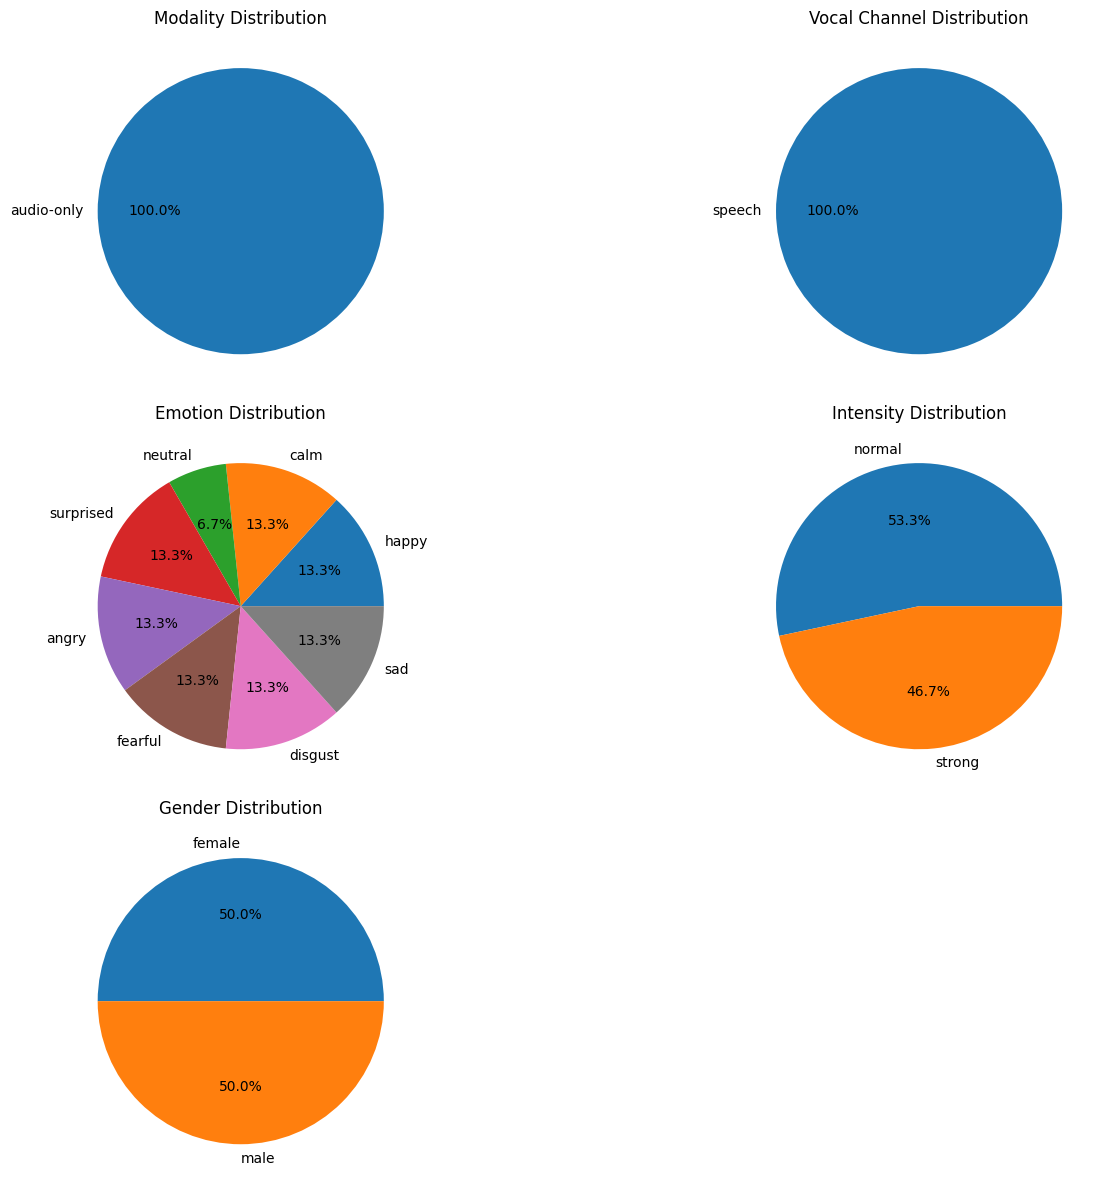


Reports displayed in the console.


In [ ]:
analyze_and_report_wav_files(dataset_path)

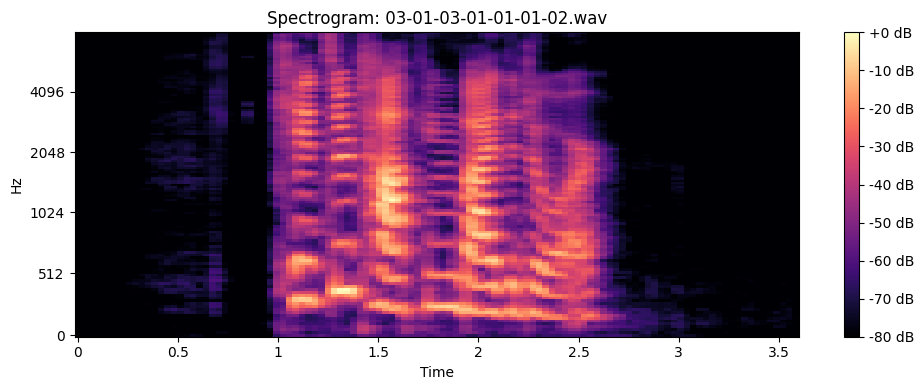

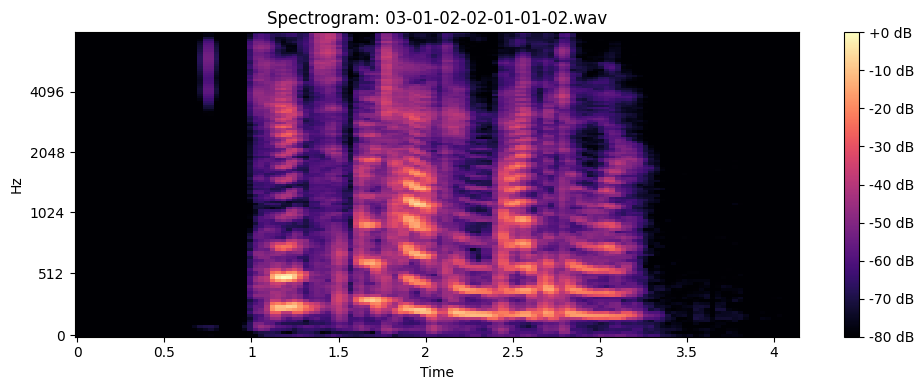

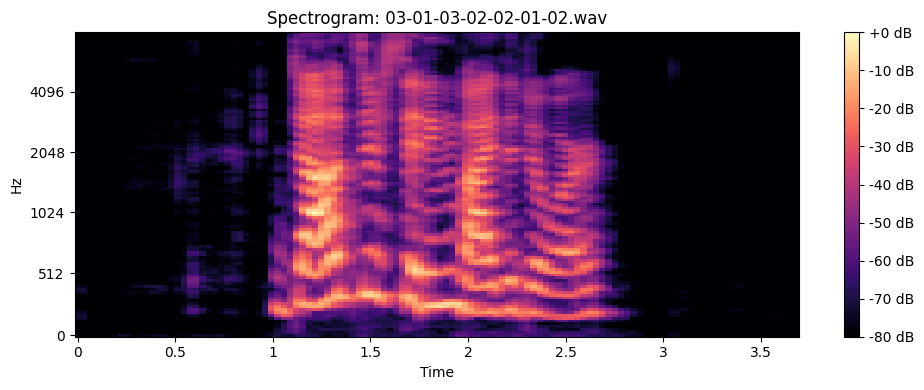

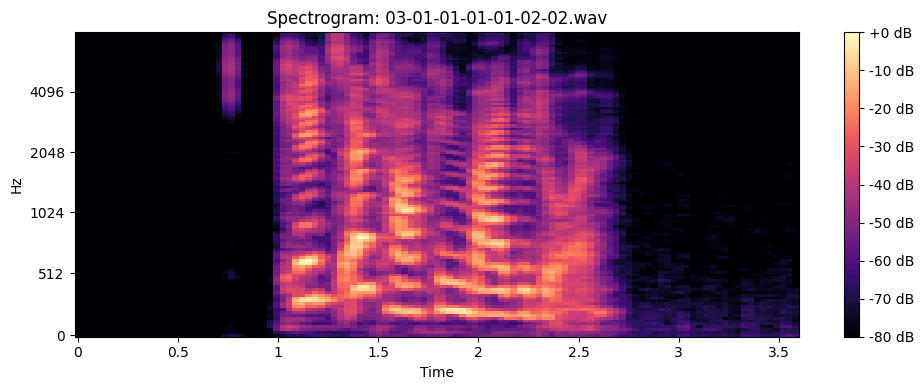

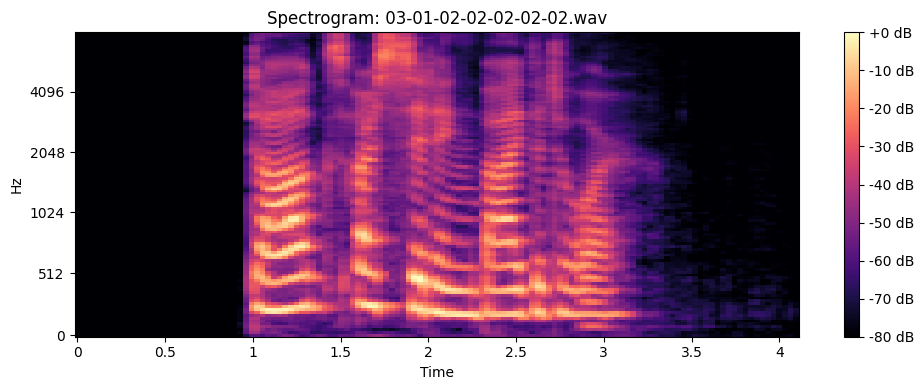

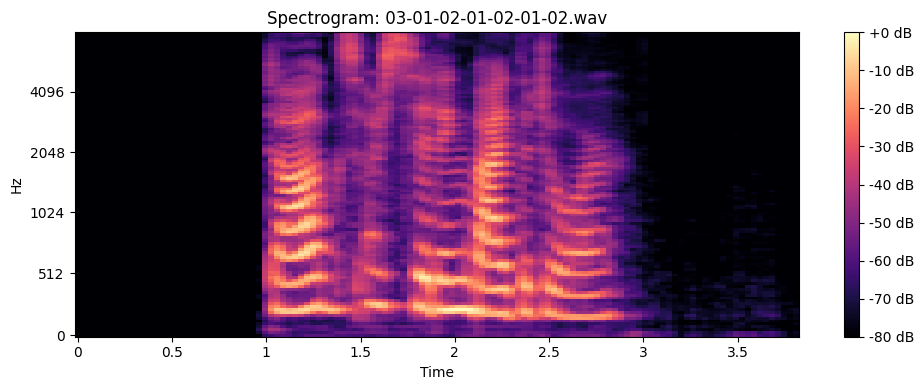

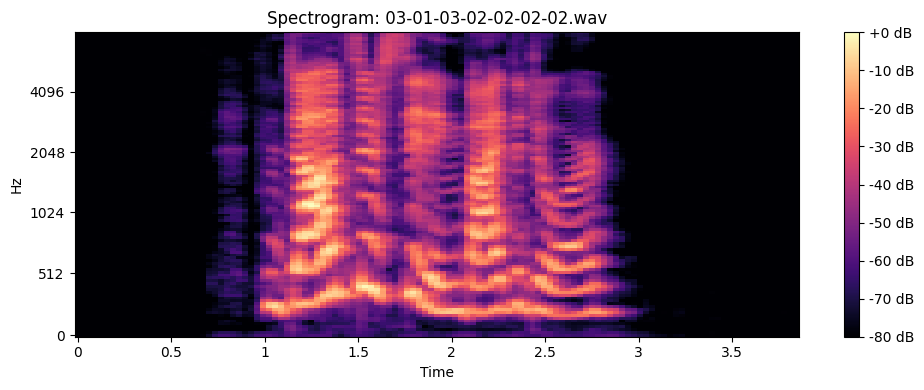

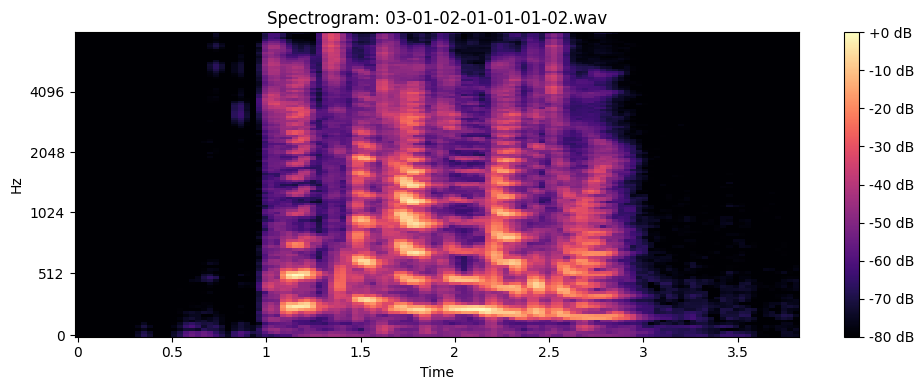

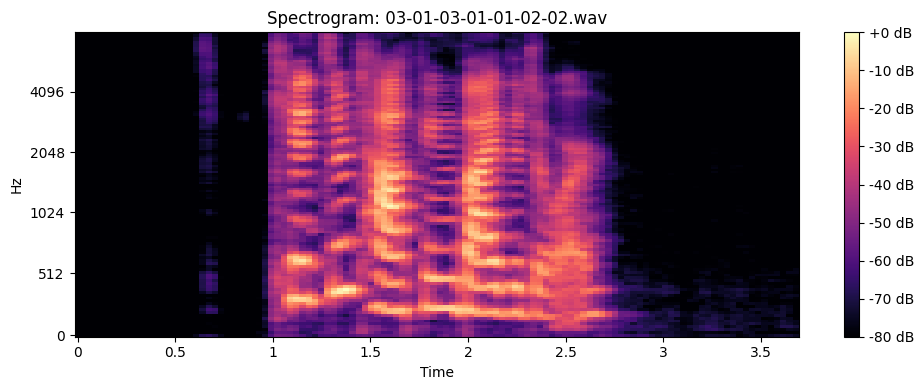

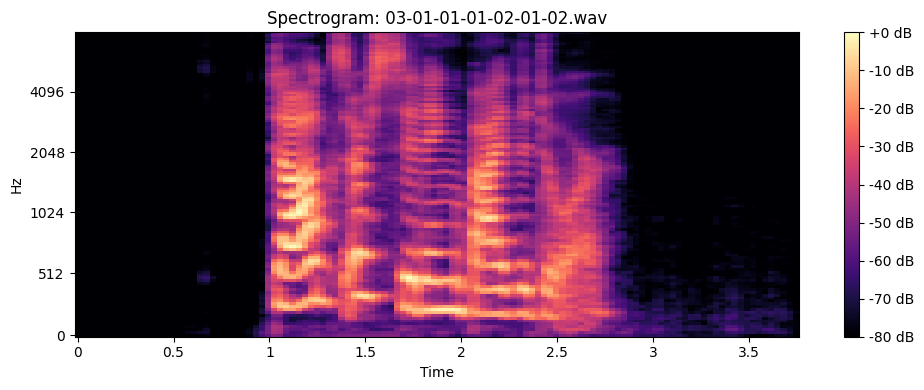

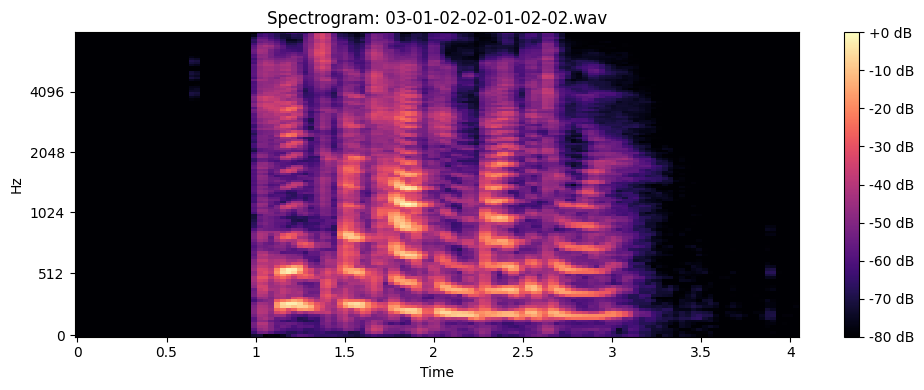

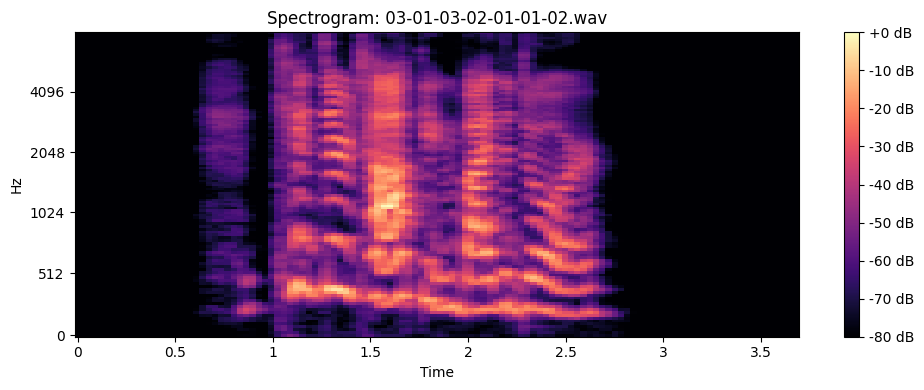

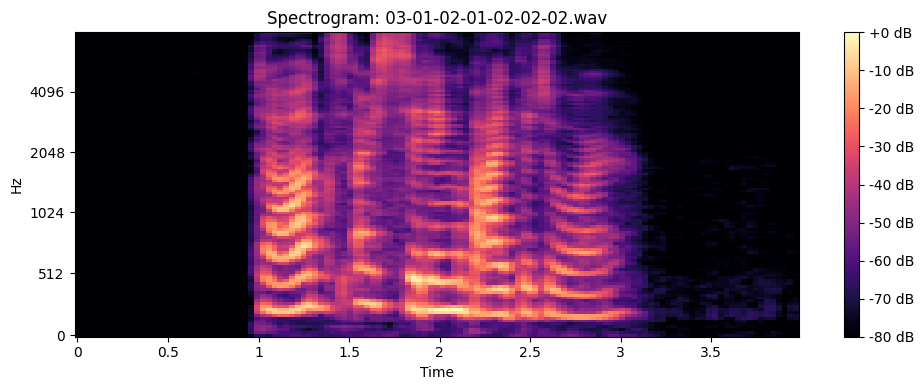

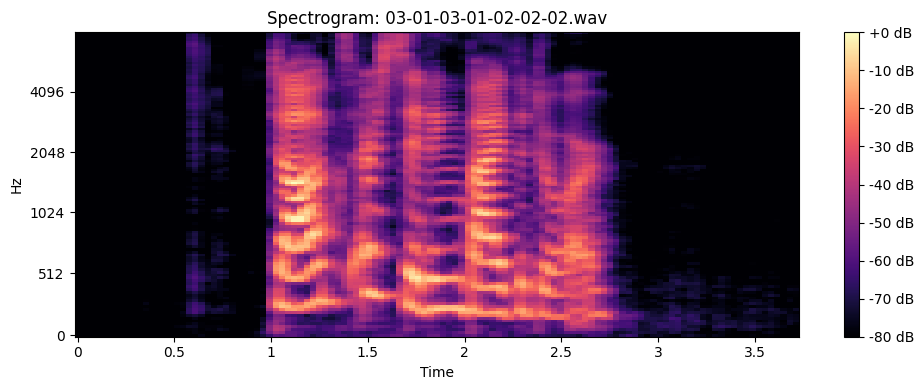

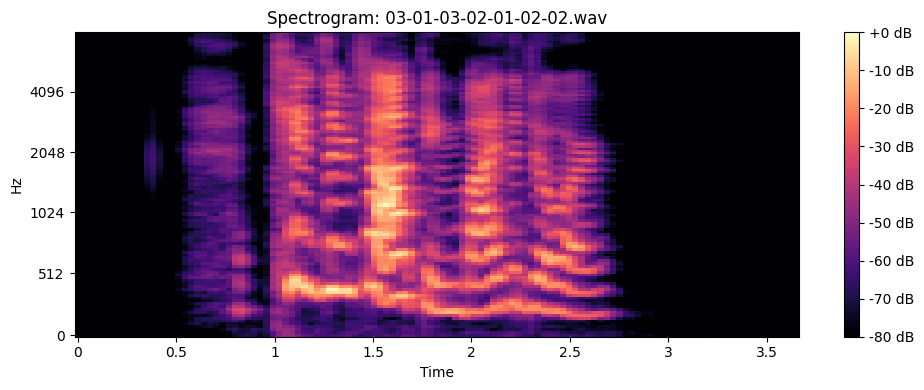

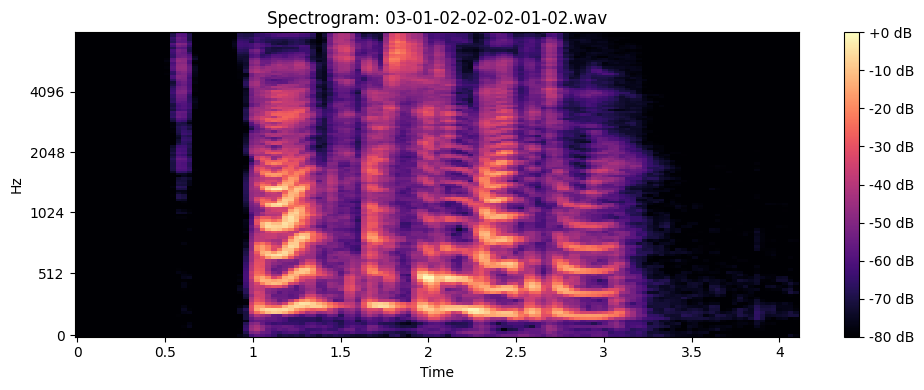

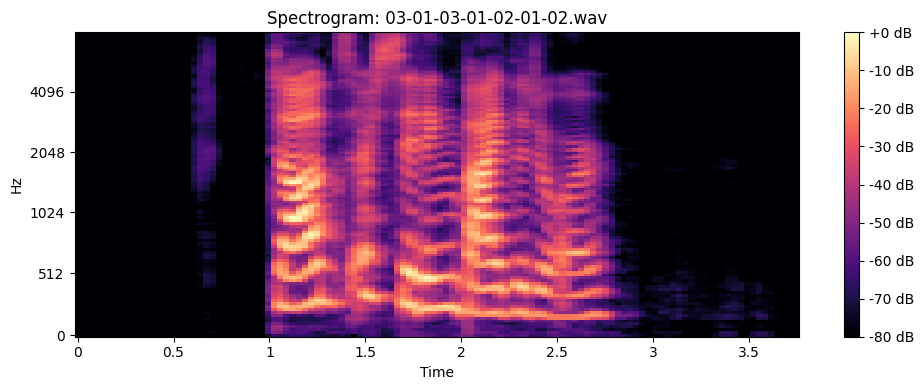

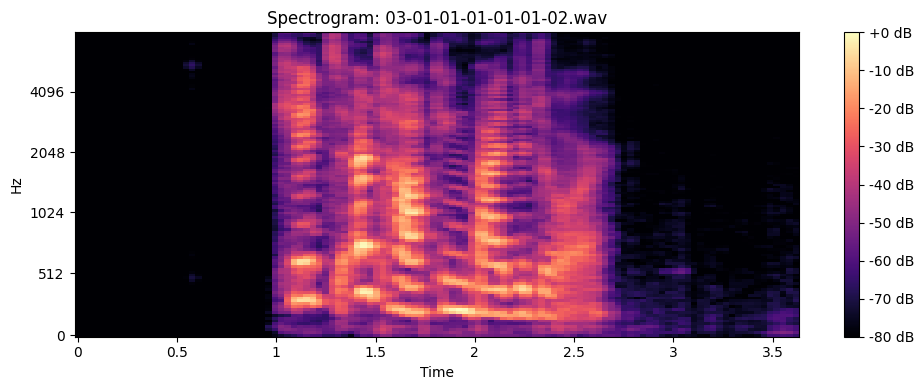

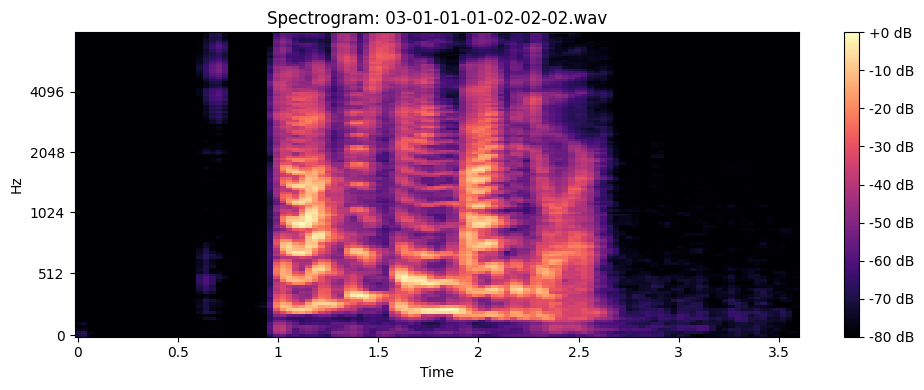

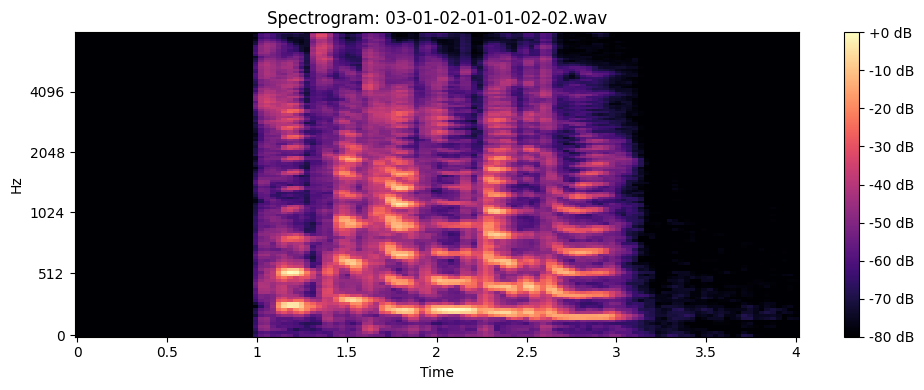

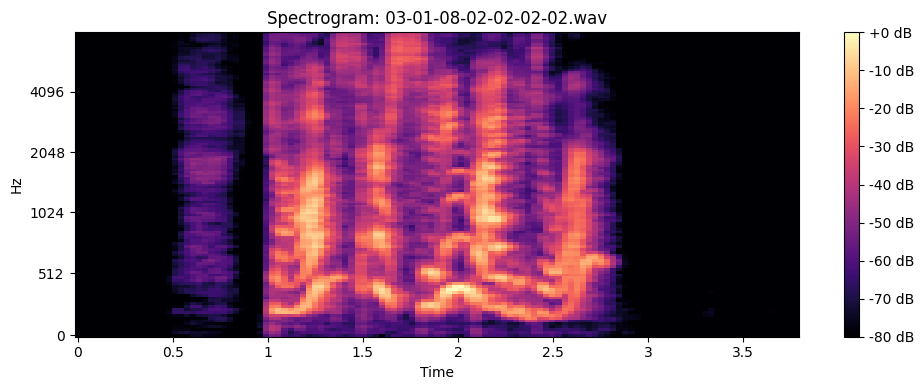

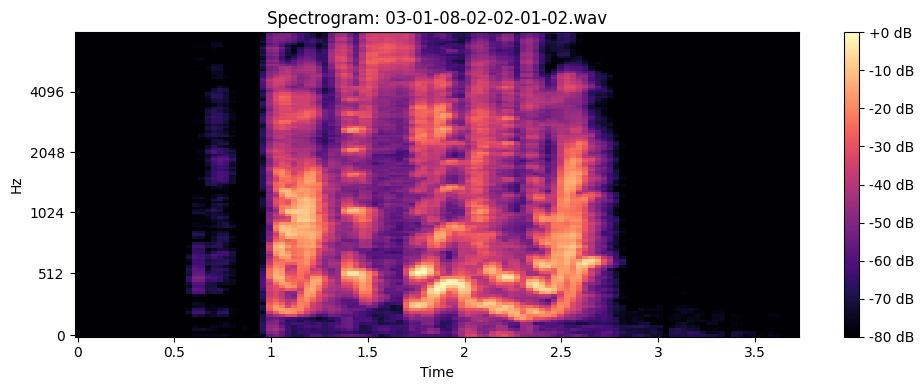

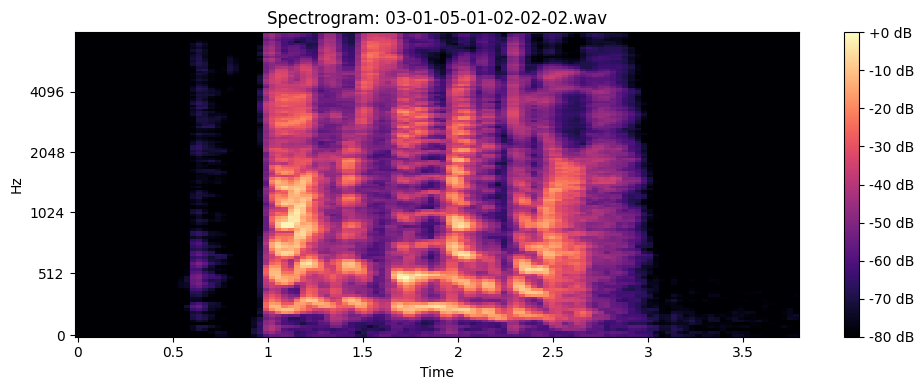

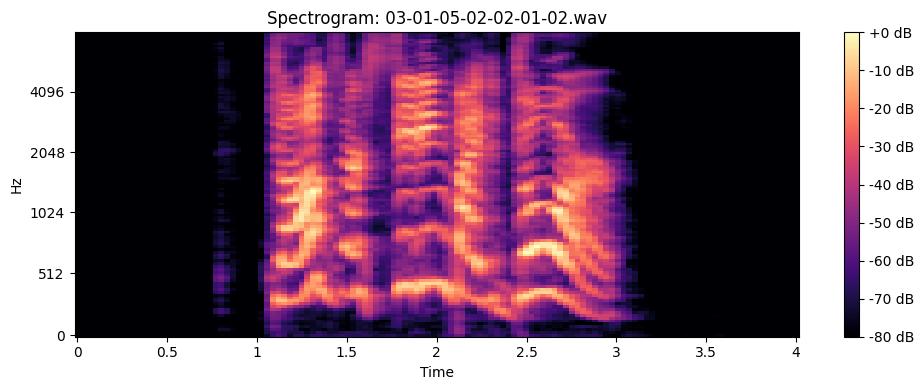

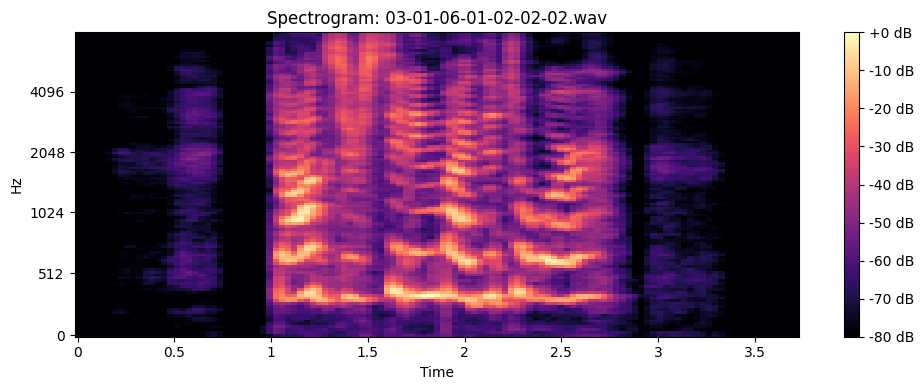

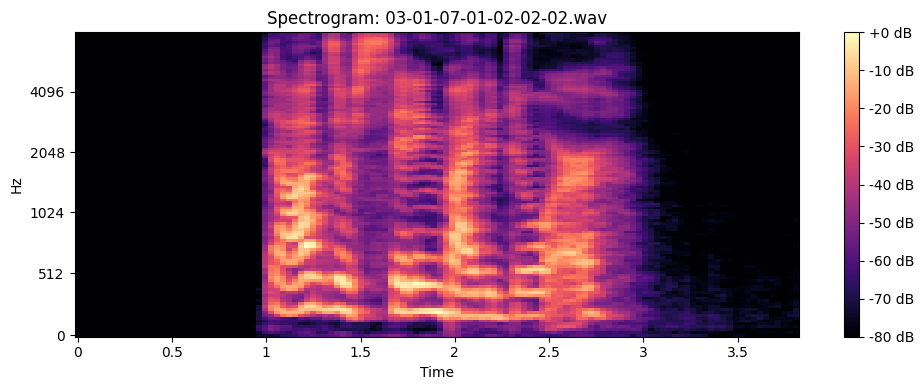

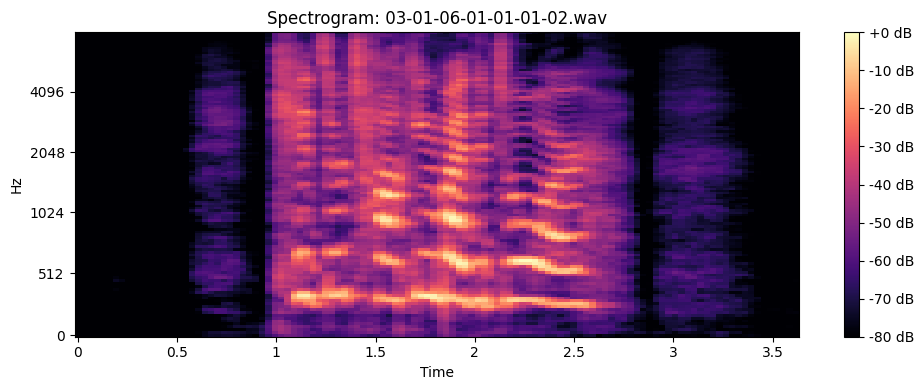

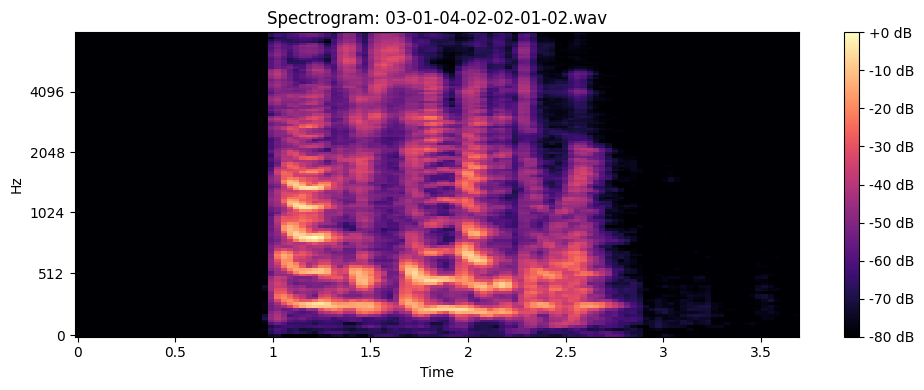

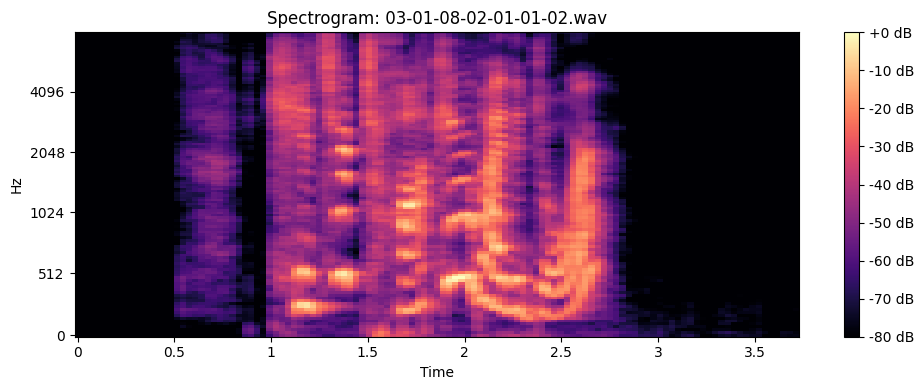

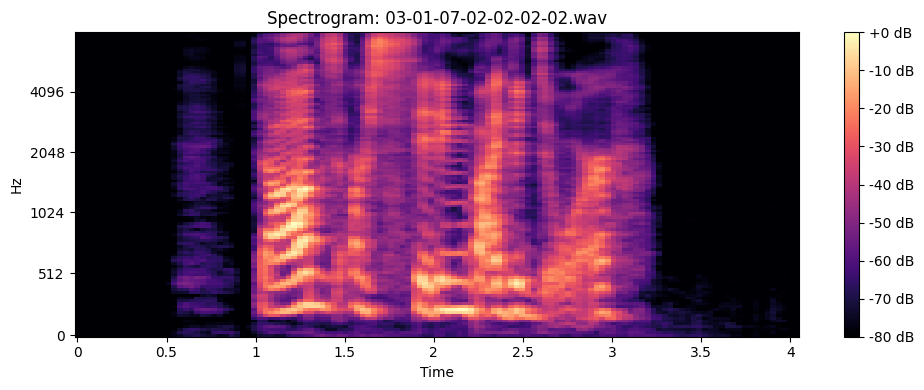

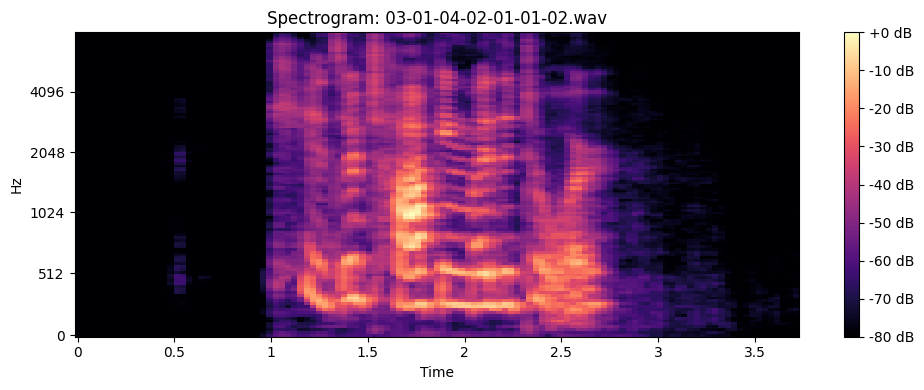

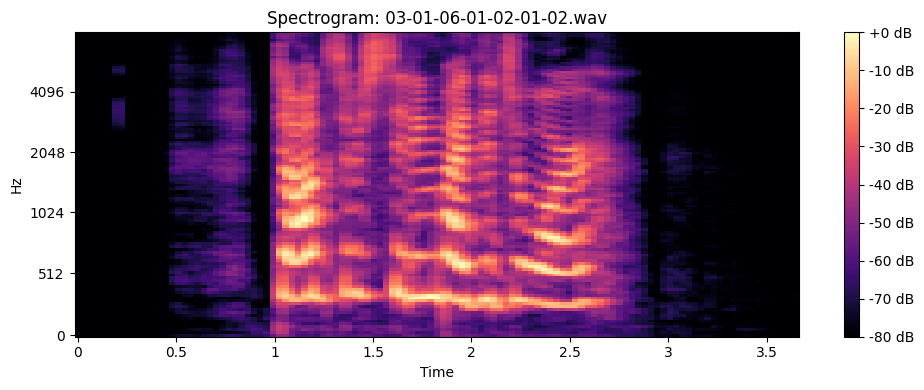

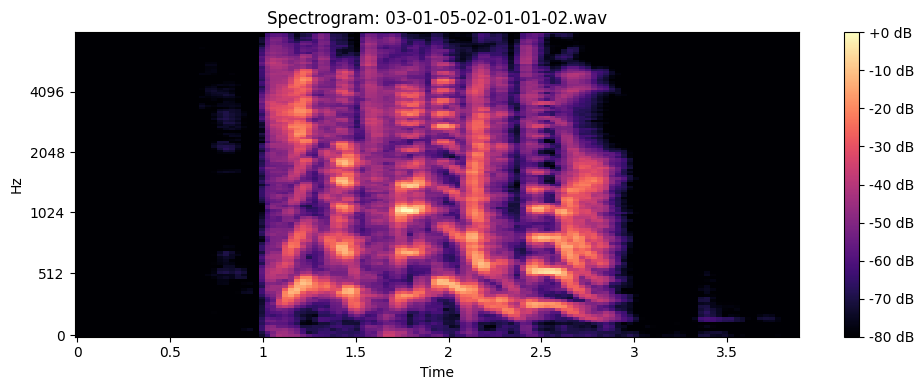

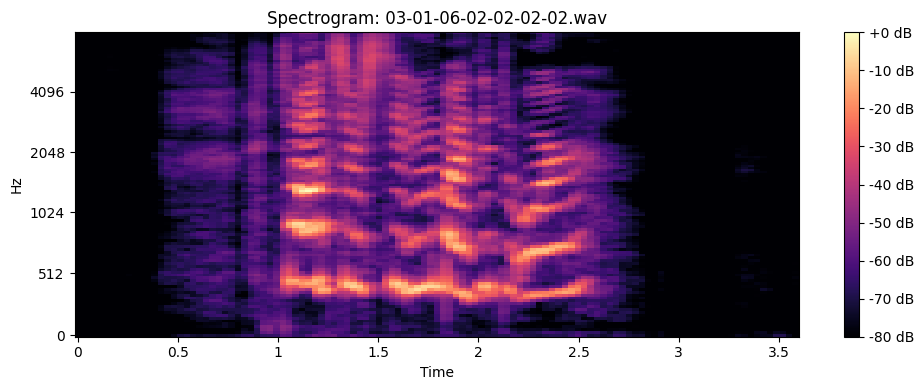

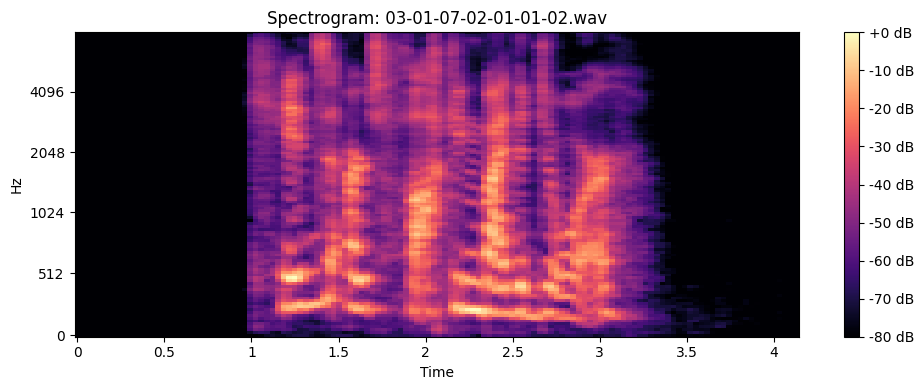

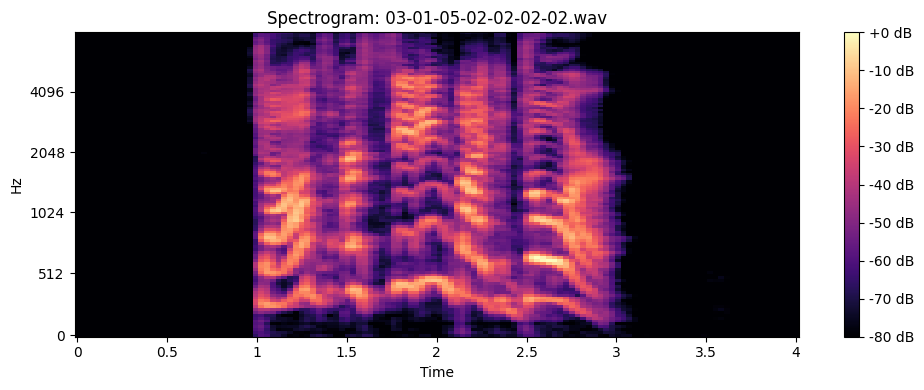

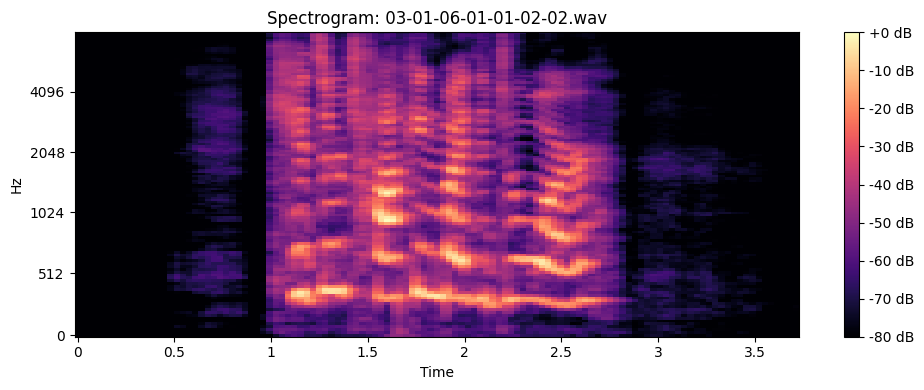

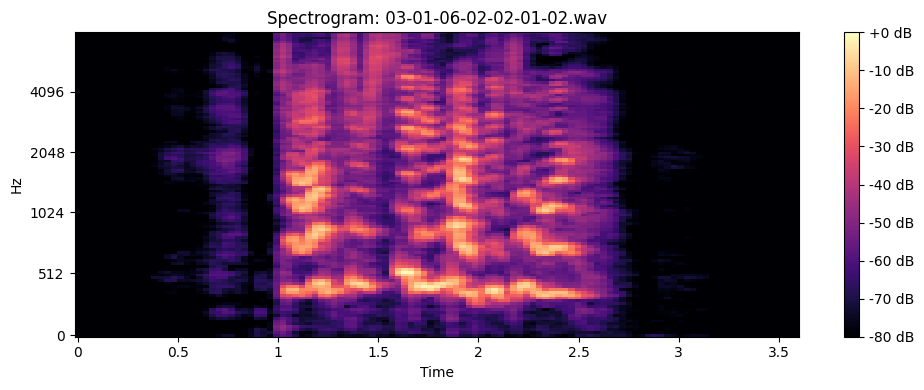

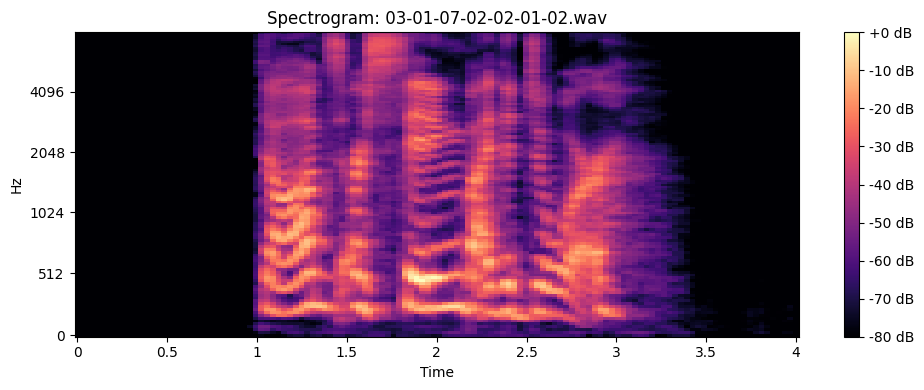

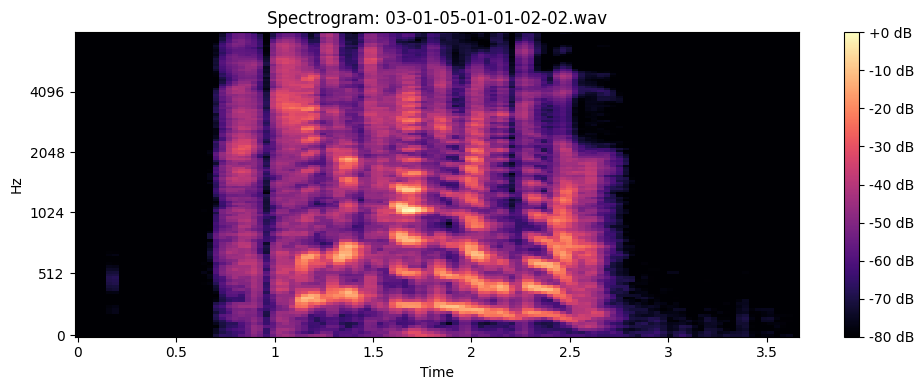

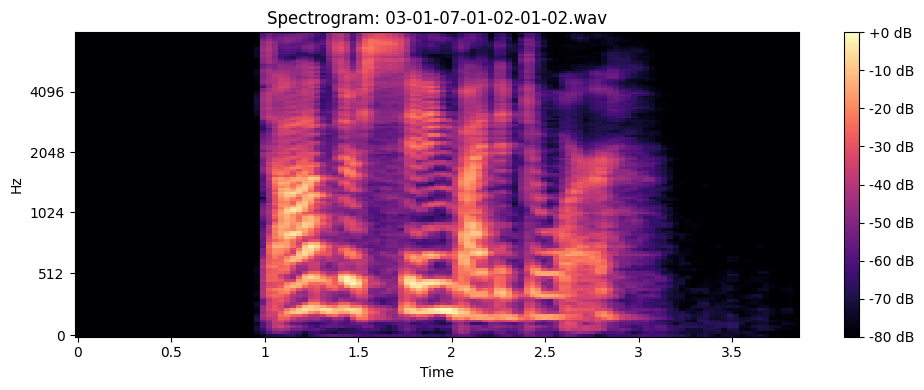

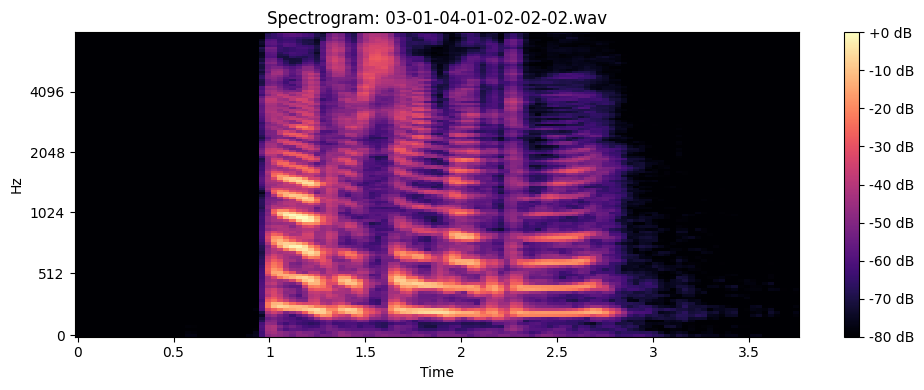

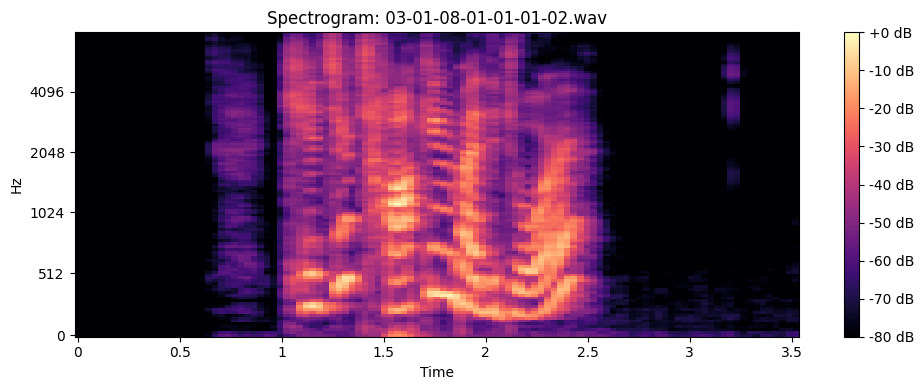

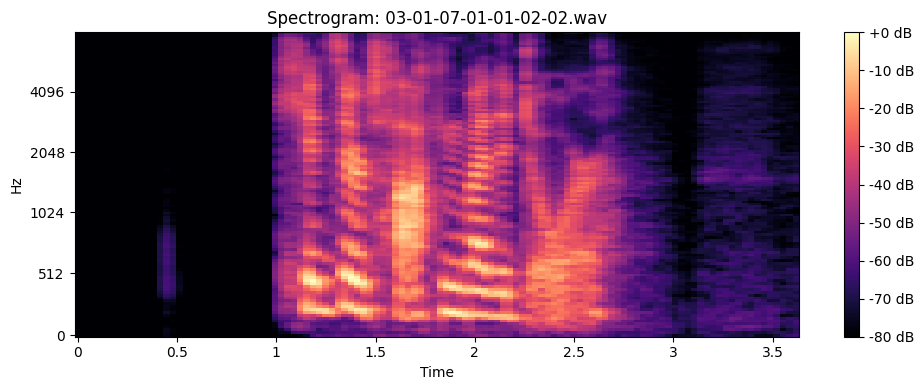

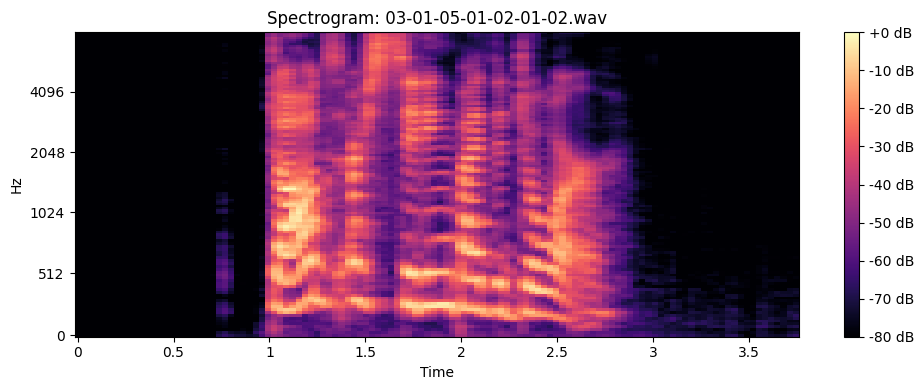

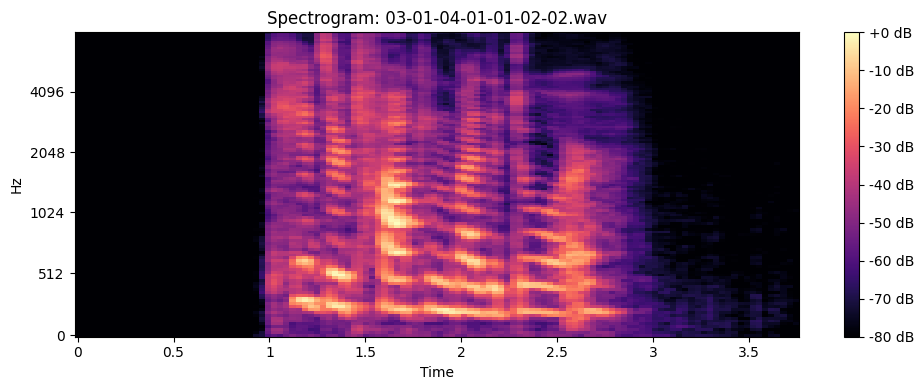

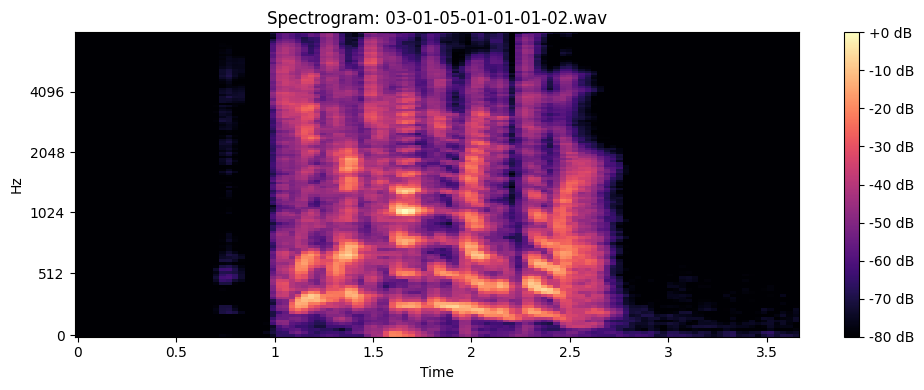

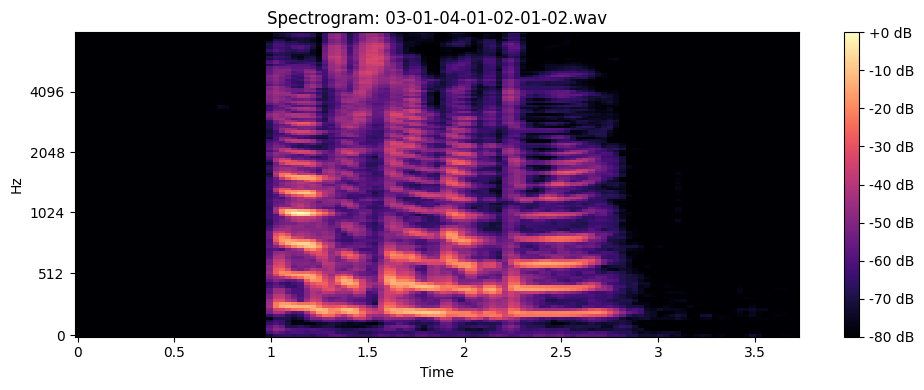

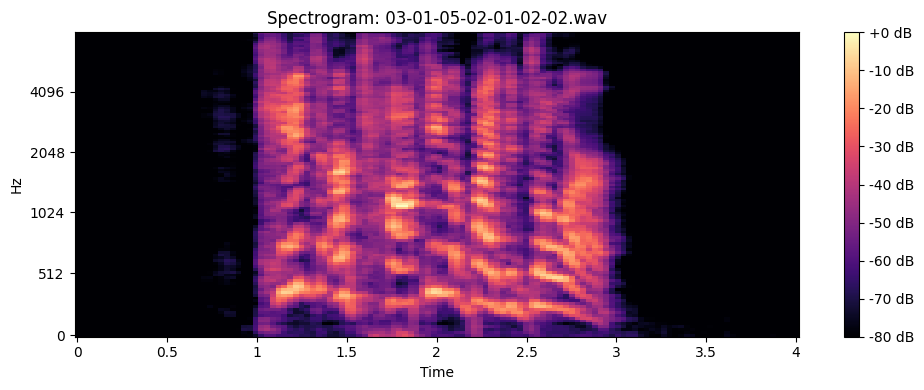

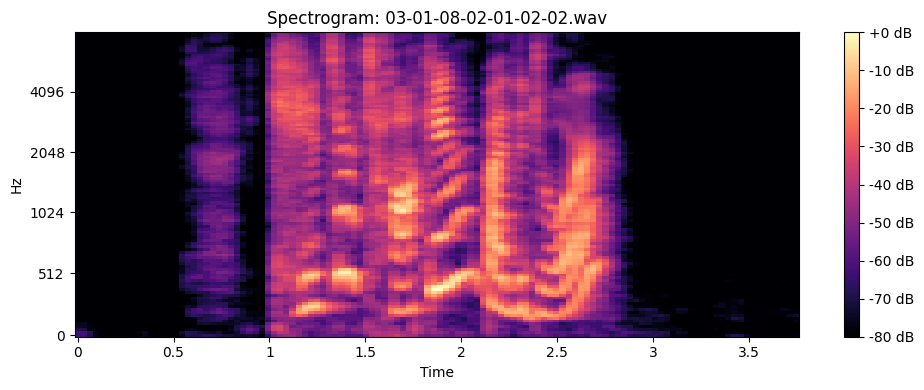

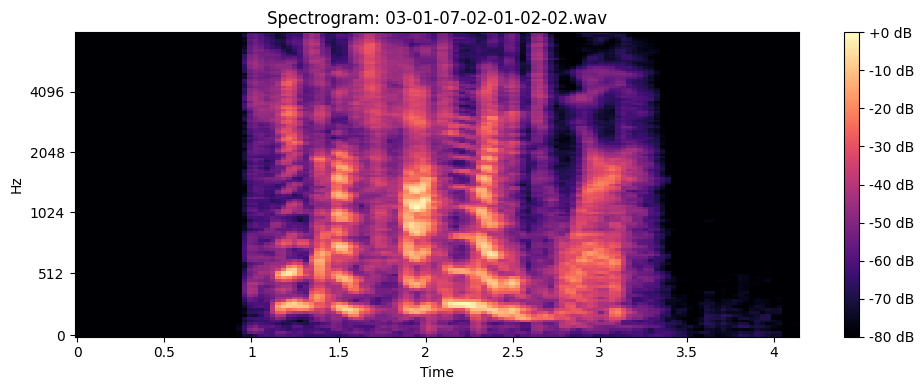

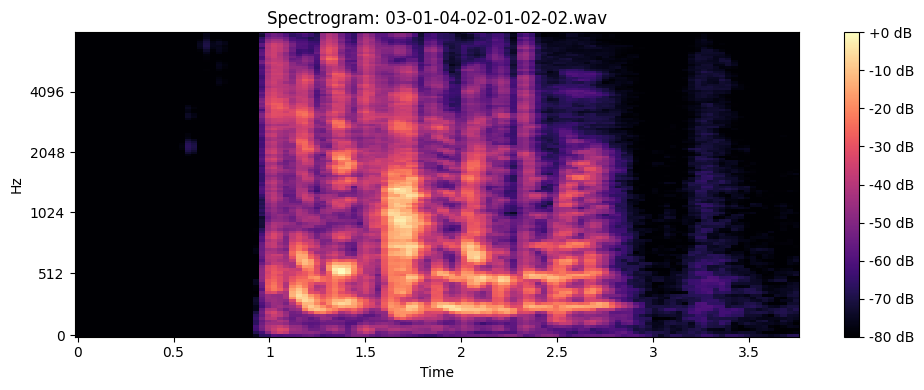

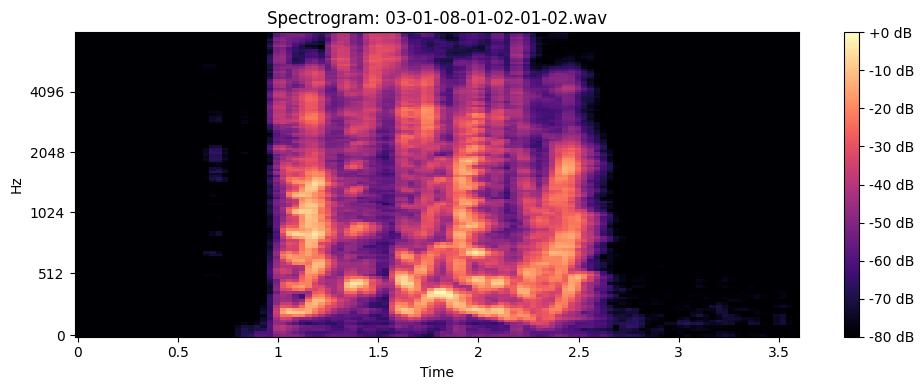

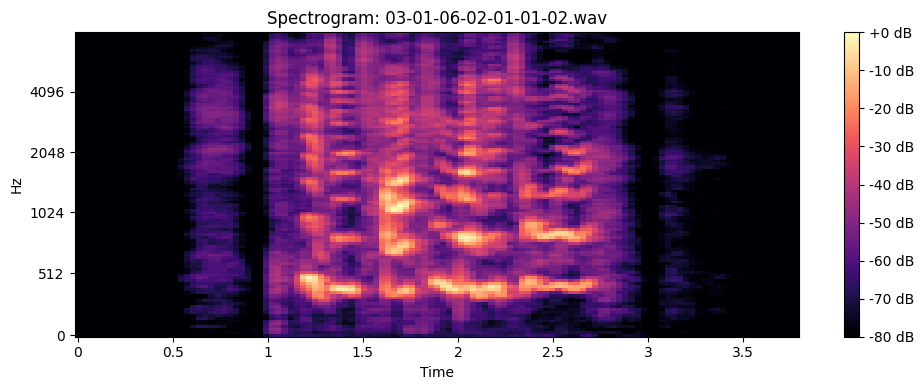

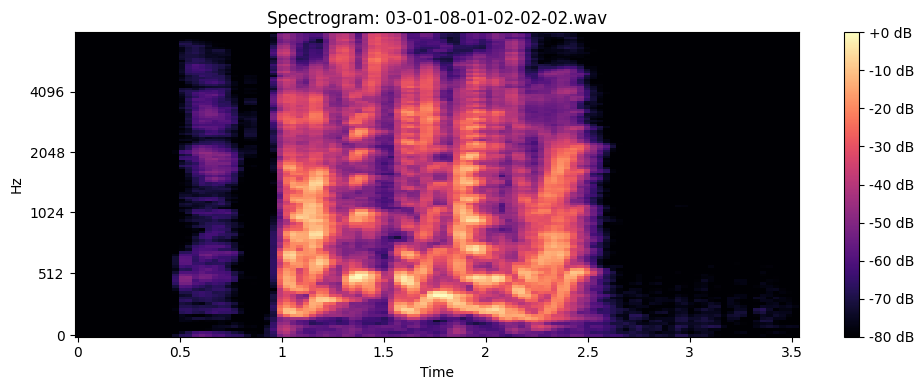

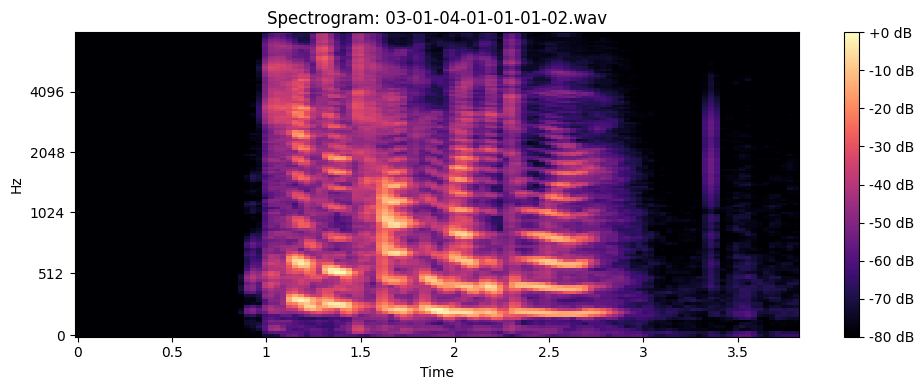

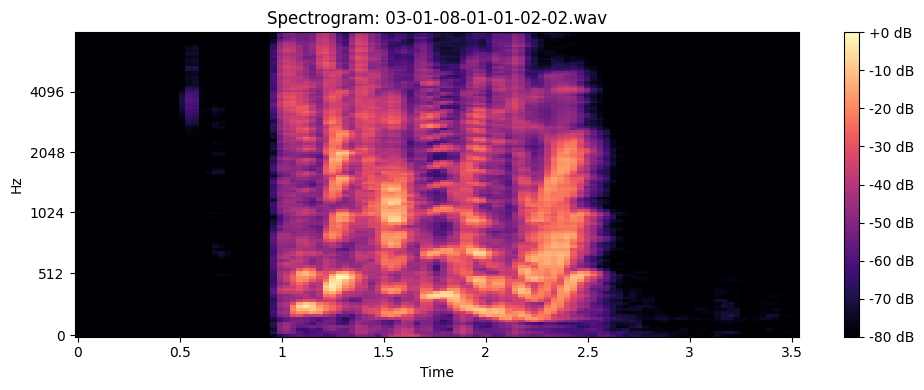

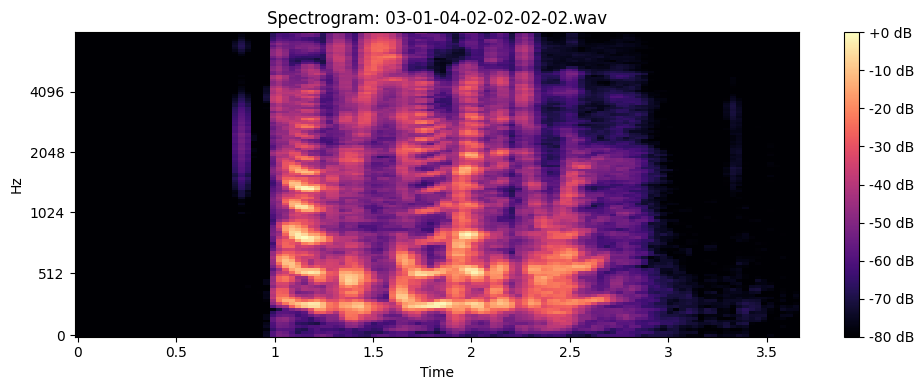

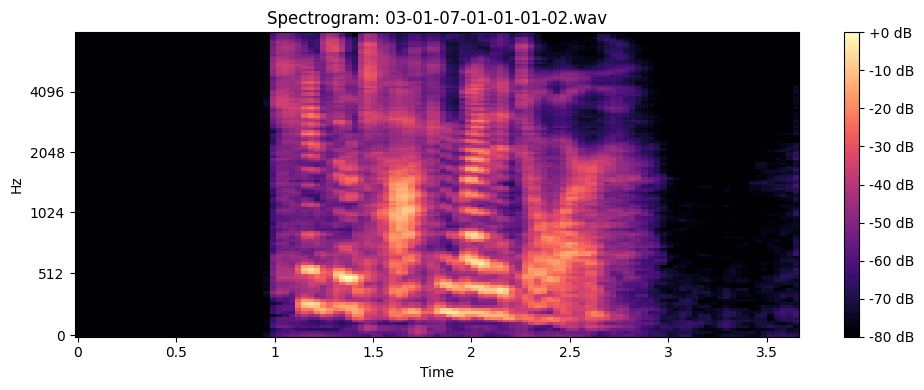

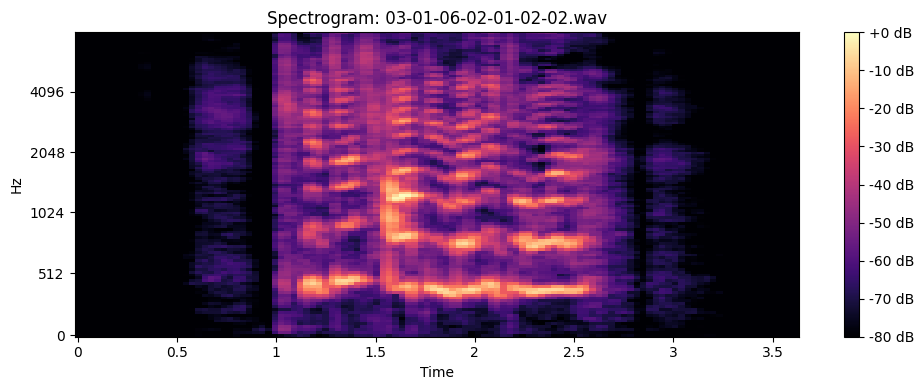

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Set dataset path
dataset_path = "/content/drive/MyDrive/PDS/PDS_PROJECT_DATA/speech-emotion-recognition-ravdess-data"

# Get list of .wav files (change max_files to limit how many to display)
wav_files = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            wav_files.append(os.path.join(root, file))
    if len(wav_files) >= 5:  # Change this number to control how many spectrograms are shown
        break

# Plot spectrograms
for file_path in wav_files:
    # Load audio
    y, sr = librosa.load(file_path, sr=None)

    # Compute Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plot
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram: {os.path.basename(file_path)}")
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import librosa
import random

# Utility: Match signal length after augmentation
def match_length(y, target_length):
    if len(y) < target_length:
        return np.pad(y, (0, target_length - len(y)))
    return y[:target_length]

# 1. Add White Noise
def add_noise(y, noise_factor=0.005):
    noise = noise_factor * np.random.randn(len(y))
    return y + noise

# 2. Time Stretch
def time_stretch(y, rate=1.1, target_length=None):
    D = librosa.stft(y)
    D_stretch = librosa.phase_vocoder(D, rate)
    y_stretch = librosa.istft(D_stretch)
    return match_length(y_stretch, target_length) if target_length else y_stretch

# 3. Pitch Shift
def pitch_shift(y, sr, n_steps=4):
    return librosa.effects.pitch_shift(y, sr, n_steps=n_steps)

# 4. Shift Sound (roll the waveform)
def shift_sound(y, shift_max=0.2):
    shift = int(random.uniform(-shift_max, shift_max) * len(y))
    return np.roll(y, shift)

# 5. Apply all augmentations
def apply_augmentations(y, sr):
    target_len = len(y)
    return {
        "original": y,
        "noise": add_noise(y),
        "stretch": time_stretch(y, rate=1.1, target_length=target_len),
        "pitch": pitch_shift(y, sr, n_steps=4),
        "shifted": shift_sound(y)
    }


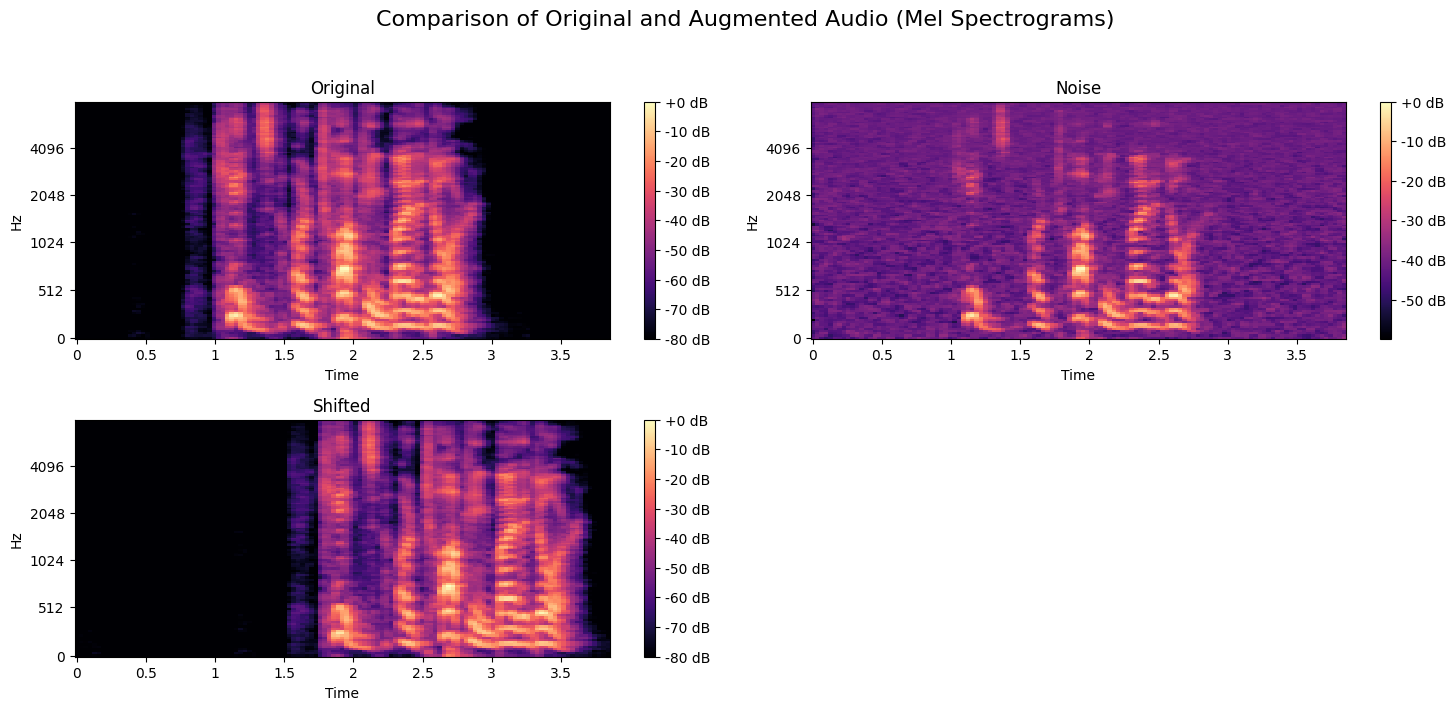

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random

# === SELECT A SPECIFIC AUDIO FILE ===
file_path = "/content/drive/MyDrive/PDS/PDS_PROJECT_DATA/speech-emotion-recognition-ravdess-data/Actor_01/03-01-05-01-01-01-01.wav"

# === AUGMENTATION UTILS ===
def match_length(y, target_length):
    if len(y) < target_length:
        return np.pad(y, (0, target_length - len(y)))
    return y[:target_length]

def add_noise(y, noise_factor=0.005):
    return y + noise_factor * np.random.randn(len(y))




def shift_sound(y, shift_max=0.2):
    shift = int(random.uniform(-shift_max, shift_max) * len(y))
    return np.roll(y, shift)

def apply_augmentations(y, sr):
    target_len = len(y)
    return {
        "Original": y,
        "Noise": add_noise(y),
        "Shifted": shift_sound(y)
    }

# === LOAD AUDIO AND AUGMENT ===
y, sr = librosa.load(file_path, sr=None)
augmented_signals = apply_augmentations(y, sr)

# === PLOT MEL SPECTROGRAMS ===
plt.figure(figsize=(15, 10))
for i, (label, signal) in enumerate(augmented_signals.items()):
    plt.subplot(3, 2, i+1)
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(label)

plt.suptitle("Comparison of Original and Augmented Audio (Mel Spectrograms)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:

import os
import librosa

audio_dir = '/content/drive/MyDrive/PDS/PDS_PROJECT_DATA/speech-emotion-recognition-ravdess-data'
augmented_data = {}

for root, _, files in os.walk(audio_dir):
    for fname in files:
        if not fname.lower().endswith('.wav'):
            continue

        # parse emotion code (3rd field) from e.g. "03-01-06-01-02-01-12.wav"
        parts = fname.split('-')
        emotion_code = parts[2]
        emotion_label = {
            '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
            '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
        }.get(emotion_code, emotion_code)

        # load file
        path = os.path.join(root, fname)
        y, sr = librosa.load(path, sr=None)

        # augment
        y_noise   = add_noise(y)
        y_stretch = librosa.effects.time_stretch(y, rate=1.1)   # <- rate must be keyword-only
        y_pitch = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=4)


        # collect into dict
        if emotion_label not in augmented_data:
            augmented_data[emotion_label] = {}
        augmented_data[emotion_label].update({
            'original': y,
            'noise':    y_noise,
            'stretch':  y_stretch,
            'pitch':    y_pitch
        })

print(f"Built augmented_data for {len(augmented_data)} emotion classes, with variants per class.")


Built augmented_data for 8 emotion classes, with variants per class.


In [ ]:

import librosa
import numpy as np
import pandas as pd

def extract_features(y, sr=22050, n_mfcc=13):
    """Extract a set of summary statistics from an audio time series."""
    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    # Mel-spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    # Tonnetz (needs the harmonic component)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

    # For each feature, compute mean and standard deviation over time
    stats = []
    for feat in [mfccs, chroma, mel, contrast, tonnetz]:
        stats.append(np.mean(feat, axis=1))
        stats.append(np.std(feat, axis=1))
    return np.hstack(stats)

# Assuming you have a dict 'augmented_data' structured as:
#   augmented_data[emotion_label] = {
#       'original': y_orig,
#       'noise': y_noise,
#       'stretch': y_stretch,
#       'pitch': y_pitch,
#       ...
#   }
# and a sample rate 'sr'.

rows = []
for emotion, variants in augmented_data.items():
    for variant_name, y_variant in variants.items():
        feat_vec = extract_features(y_variant, sr=sr)
        rows.append({
            'emotion': emotion,
            'variant': variant_name,
            **{f'f{i+1}': feat for i, feat in enumerate(feat_vec)}
        })

features_df = pd.DataFrame(rows)
print("Extracted feature matrix shape:", features_df.shape)
features_df.head()

# You can now use `features_df` for downstream modeling or visualization.


Extracted feature matrix shape: (32, 334)


emotion   variant          f1         f2         f3         f4         f5  \
0   happy  original -495.576782  11.650211 -21.840162  -6.352988 -20.073908   
1   happy     noise -266.983143   8.371705  -5.938495  -5.554313  -5.644103   
2   happy   stretch -509.381439  12.584217 -24.613226  -9.105054 -21.186100   
3   happy     pitch -525.867249   2.509046 -29.765924 -12.621187 -27.125391   
4    calm  original -684.253906  37.808414  -0.393736  -0.190155  -2.567374   

          f6         f7         f8  ...      f323      f324      f325  \
0 -14.741199 -13.168602 -10.453532  ... -0.027645  0.037898 -0.001897   
1  -4.487367  -4.978689  -3.386167  ... -0.019674  0.013542 -0.010378   
2 -15.680207 -14.990541 -11.168181  ... -0.018180  0.050587 -0.001922   
3 -12.187161 -15.910378  -4.748474  ... -0.024689  0.017893 -0.019326   
4 -10.388621 -13.640526  -9.459058  ... -0.008755  0.064984 -0.014269   

       f326      f327      f328      f329      f330      f331      f332  
0 -0.017497  0.094553  0.133020  0.221166  0.142006  0.070276  0.062787  
1 -0.018521  0.082208  0.127709  0.171561  0.112956  0.055743  0.046083  
2 -0.023894  0.116464  0.156152  0.233462  0.134058  0.081562  0.066859  
3  0.031692  0.159656  0.097983  0.226381  0.124871  0.064375  0.066734  
4 -0.012262  0.128193  0.097874  0.221610  0.181238  0.069680  0.067445  

[5 rows x 334 columns]

In [ ]:


import os
import glob
import numpy as np
import pandas as pd
import librosa

# 1) Root folder containing sub-dirs of your 1 440 WAVs
audio_root = dataset_path

# 2) Augmentation helpers—all take (y, sr) and return a same-length y_aug
def identity(y, sr):
    return y

def add_noise(y, sr, noise_factor=0.005):
    return y + noise_factor * np.random.randn(len(y))

def stretch_fn(y, sr):
    # approximate time-stretch by resampling
    rate = 1.1
    y_stretch = librosa.resample(y, orig_sr=sr, target_sr=int(sr / rate))
    if len(y_stretch) >= len(y):
        return y_stretch[:len(y)]
    else:
        return np.pad(y_stretch, (0, len(y) - len(y_stretch)), mode='constant')

def pitch_fn(y, sr, n_steps=4):
    # approximate pitch shift via resampling up/down
    rate = 2.0 ** (n_steps / 12)
    y_scaled = librosa.resample(y, orig_sr=sr, target_sr=int(sr * rate))
    y_shifted = librosa.resample(y_scaled, orig_sr=int(sr * rate), target_sr=sr)
    if len(y_shifted) >= len(y):
        return y_shifted[:len(y)]
    else:
        return np.pad(y_shifted, (0, len(y) - len(y_shifted)), mode='constant')

# 3) Map the 3rd token in filename → emotion
emotion_map = {
    '01':'neutral','02':'calm','03':'happy','04':'sad',
    '05':'angry','06':'fearful','07':'disgust','08':'surprised'
}

# 4) Bundle your variants
variants = {
    'orig':    identity,
    'noise':   add_noise,
    'stretch': stretch_fn,
    'pitch':   pitch_fn
}

# 5) Recursively find all WAVs
wav_paths = glob.glob(os.path.join(audio_root, '**', '*.wav'), recursive=True)
wav_count = len(wav_paths)
variant_count = len(variants)

records = []
for fp in wav_paths:
    tok = os.path.basename(fp)[:-4].split('-')[2]
    emo = emotion_map.get(tok, 'unknown')
    y, sr = librosa.load(fp, sr=22050)

    for var_name, fn in variants.items():
        y_aug = fn(y, sr)

        # compute 128-mel spectrogram → dB → normalize
        S      = librosa.feature.melspectrogram(y=y_aug, sr=sr,
                                                n_fft=2048, hop_length=512, n_mels=128)
        S_db   = librosa.power_to_db(S, ref=np.max)
        S_norm = (S_db - S_db.mean()) / (S_db.std() + 1e-6)

        records.append({
            'feature': S_norm.flatten(),
            'emotion': emo,
            'variant': var_name
        })

# 6) Build DataFrame
features_df = pd.DataFrame(records)

# 7) Sanity-check
print(f"Found {wav_count} WAV files")
print(f"{variant_count} variants each → expecting {wav_count * variant_count} rows")
print(f"features_df shape: {features_df.shape}")


Found 1440 WAV files
4 variants each → expecting 5760 rows
features_df shape: (5760, 3)


In [ ]:

import numpy as np
from sklearn.model_selection import train_test_split

# 1) Determine the maximum feature-vector length
lengths = [feat.shape[0] for feat in features_df['feature'].values]
max_len = max(lengths)
print(f"Maximum flattened feature length: {max_len}")

# 2) Pad each feature vector to `max_len`
X = np.stack([
    np.pad(feat, (0, max_len - feat.shape[0]), mode='constant')
    for feat in features_df['feature'].values
])

# 3) Labels
y = features_df['emotion'].values

# 4) Stratified split: 75% train / 25% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"Total samples: {X.shape[0]}")
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test  shape: {X_test.shape},  y_test  shape: {y_test.shape}")


Maximum flattened feature length: 29184
Total samples: 5760
Train samples: 4320, Test samples: 1440
X_train shape: (4320, 29184), y_train shape: (4320,)
X_test  shape: (1440, 29184),  y_test  shape: (1440,)


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report


In [ ]:

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Logistic Regression
Accuracy: 0.7222222222222222
              precision    recall  f1-score   support

       angry       0.77      0.70      0.73       192
        calm       0.73      0.77      0.75       192
     disgust       0.75      0.69      0.72       192
     fearful       0.80      0.80      0.80       192
       happy       0.71      0.65      0.68       192
     neutral       0.66      0.66      0.66        96
         sad       0.65      0.71      0.68       192
   surprised       0.70      0.77      0.73       192

    accuracy                           0.72      1440
   macro avg       0.72      0.72      0.72      1440
weighted avg       0.72      0.72      0.72      1440



In [ ]:

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Random Forest
Accuracy: 0.61875
              precision    recall  f1-score   support

       angry       0.65      0.66      0.65       192
        calm       0.70      0.72      0.71       192
     disgust       0.58      0.68      0.62       192
     fearful       0.62      0.63      0.63       192
       happy       0.62      0.50      0.55       192
     neutral       0.75      0.47      0.58        96
         sad       0.70      0.55      0.61       192
   surprised       0.49      0.68      0.57       192

    accuracy                           0.62      1440
   macro avg       0.64      0.61      0.62      1440
weighted avg       0.63      0.62      0.62      1440



In [ ]:
# ─── Cell: Random Forest Predictions on Original Dataset Samples ───
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Train a Random Forest on the training set
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Sample 30 random examples from the original dataset (X, y)
np.random.seed(42)
sample_indices = np.random.choice(np.arange(X.shape[0]), size=30, replace=False)
X_samples = X[sample_indices]
y_actual = y[sample_indices]

# Predict on those samples
y_pred_rf = rf.predict(X_samples)

print("Random Forest Predictions on 30 Original Samples")
for idx, pred, actual in zip(sample_indices, y_pred_rf, y_actual):
    print(f"Index {idx:3d} → Predicted: {pred}, Actual: {actual}")


Random Forest Predictions on 30 Original Samples
Index 4382 → Predicted: angry, Actual: angry
Index 5060 → Predicted: calm, Actual: calm
Index 2187 → Predicted: calm, Actual: calm
Index 4813 → Predicted: neutral, Actual: neutral
Index 5298 → Predicted: calm, Actual: calm
Index 1101 → Predicted: surprised, Actual: surprised
Index 2210 → Predicted: calm, Actual: calm
Index 3807 → Predicted: angry, Actual: angry
Index 3524 → Predicted: surprised, Actual: surprised
Index 5462 → Predicted: fearful, Actual: fearful
Index 2462 → Predicted: sad, Actual: disgust
Index 2364 → Predicted: angry, Actual: angry
Index 4622 → Predicted: happy, Actual: happy
Index 1499 → Predicted: sad, Actual: sad
Index 132 → Predicted: fearful, Actual: fearful
Index 1718 → Predicted: sad, Actual: sad
Index 1835 → Predicted: fearful, Actual: fearful
Index 530 → Predicted: calm, Actual: calm
Index 2596 → Predicted: angry, Actual: angry
Index 157 → Predicted: angry, Actual: angry
Index 5629 → Predicted: calm, Actual: ca